In [1]:
import zipfile
import json
import os
from collections import defaultdict
from tqdm import tqdm
import shutil
import random

In [ ]:
def count_images(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zipf:
        return len([f for f in zipf.namelist() if f.lower().endswith('.jpg')])

def extract_anns(zip_path, json_filename='cocotext.v2.json'):
    with zipfile.ZipFile(zip_path, 'r') as zipf:
        with zipf.open(json_filename) as json_file:
            return json.load(json_file)
        
def contar_labeled(coco_text_data):
    etiquetadas = set()
    for ann_id, ann in coco_text_data['anns'].items():
        img_id = ann['image_id']
        if ann['legibility'] in ['legible', 'illegible']:
            etiquetadas.add(img_id)
    return len(etiquetadas)


In [ ]:
train_zip = '../data/raw/train2014.zip'
val_zip = '../data/raw/val2014.zip'
annotations_zip = '../data/raw/cocotext.v2.zip'

num_train_imgs = count_images(train_zip)
num_val_imgs = count_images(val_zip)

coco_text = extract_anns(annotations_zip)

num_etiquetadas = contar_labeled(coco_text)

print(f'Imágenes en train2014.zip: {num_train_imgs}')
print(f'Imágenes en val2014.zip: {num_val_imgs}')
print(f'Imágenes etiquetadas (con texto): {num_etiquetadas}')

Imágenes en train2014.zip: 82783
Imágenes en val2014.zip: 40504
Imágenes etiquetadas (con texto): 23485


In [ ]:
def image_id_to_train_filename(image_id):
    return f'COCO_train2014_{image_id:012d}.jpg'


def load_annotations(zip_path, json_filename='cocotext.v2.json'):
    with zipfile.ZipFile(zip_path, 'r') as zipf:
        with zipf.open(json_filename) as file:
            return json.load(file)


def get_annotated_image_ids(coco_data):
    annotated_ids = set()
    for ann in coco_data['anns'].values():
        annotated_ids.add(ann['image_id'])
    return annotated_ids


def extract_annotated_images(zip_path, output_dir, target_filenames):
    os.makedirs(output_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, 'r') as zipf:
        zip_files = zipf.namelist()
        # Match full paths like 'train2014/COCO_train2014_000000001234.jpg'
        matched_files = [f for f in zip_files if os.path.basename(f) in target_filenames]

        if not matched_files:
            print(f'No matching files found in {zip_path}')
            return

        for file in tqdm(matched_files, desc=f'Extracting from {os.path.basename(zip_path)}'):
            zipf.extract(file, output_dir)

In [ ]:
output_dir = '../data/raw/subset/train2014'

# load annotations and get annotated image IDs
coco_data = load_annotations(annotations_zip)
annotated_ids = get_annotated_image_ids(coco_data)

# convert IDs to expected filenames
train_filenames = set(image_id_to_train_filename(img_id) for img_id in annotated_ids)

# extract only annotated images from train2014.zip
extract_annotated_images(train_zip, output_dir, train_filenames)

Extracting from train2014.zip: 100%|██████████| 23485/23485 [01:13<00:00, 320.52it/s]


In [53]:
23485 / 3

7828.333333333333

In [ ]:
def split_validation_set(source_dir, target_dir, val_count=7829, seed=42, move=False):

    os.makedirs(target_dir, exist_ok=True)
    
    all_images = [f for f in os.listdir(source_dir) if f.lower().endswith('.jpg')]
    
    if val_count > len(all_images):
        raise ValueError(f"Se solicitaron {val_count} imágenes, pero solo hay {len(all_images)} disponibles.")
    
    random.seed(seed)
    selected_images = random.sample(all_images, val_count)
    
    for filename in selected_images:
        src_path = os.path.join(source_dir, filename)
        dst_path = os.path.join(target_dir, filename)
        if move:
            shutil.move(src_path, dst_path)
        else:
            shutil.copy2(src_path, dst_path)

    print(f"{val_count} imágenes {'movidas' if move else 'copiadas'} a '{target_dir}'.")

In [56]:
split_validation_set(
    source_dir='../data/raw/subset/train2014/train2014',
    target_dir='../data/raw/subset/val2014',
    val_count=7829,
    move=True  
)

7829 imágenes movidas a '../data/raw/subset/val2014'.


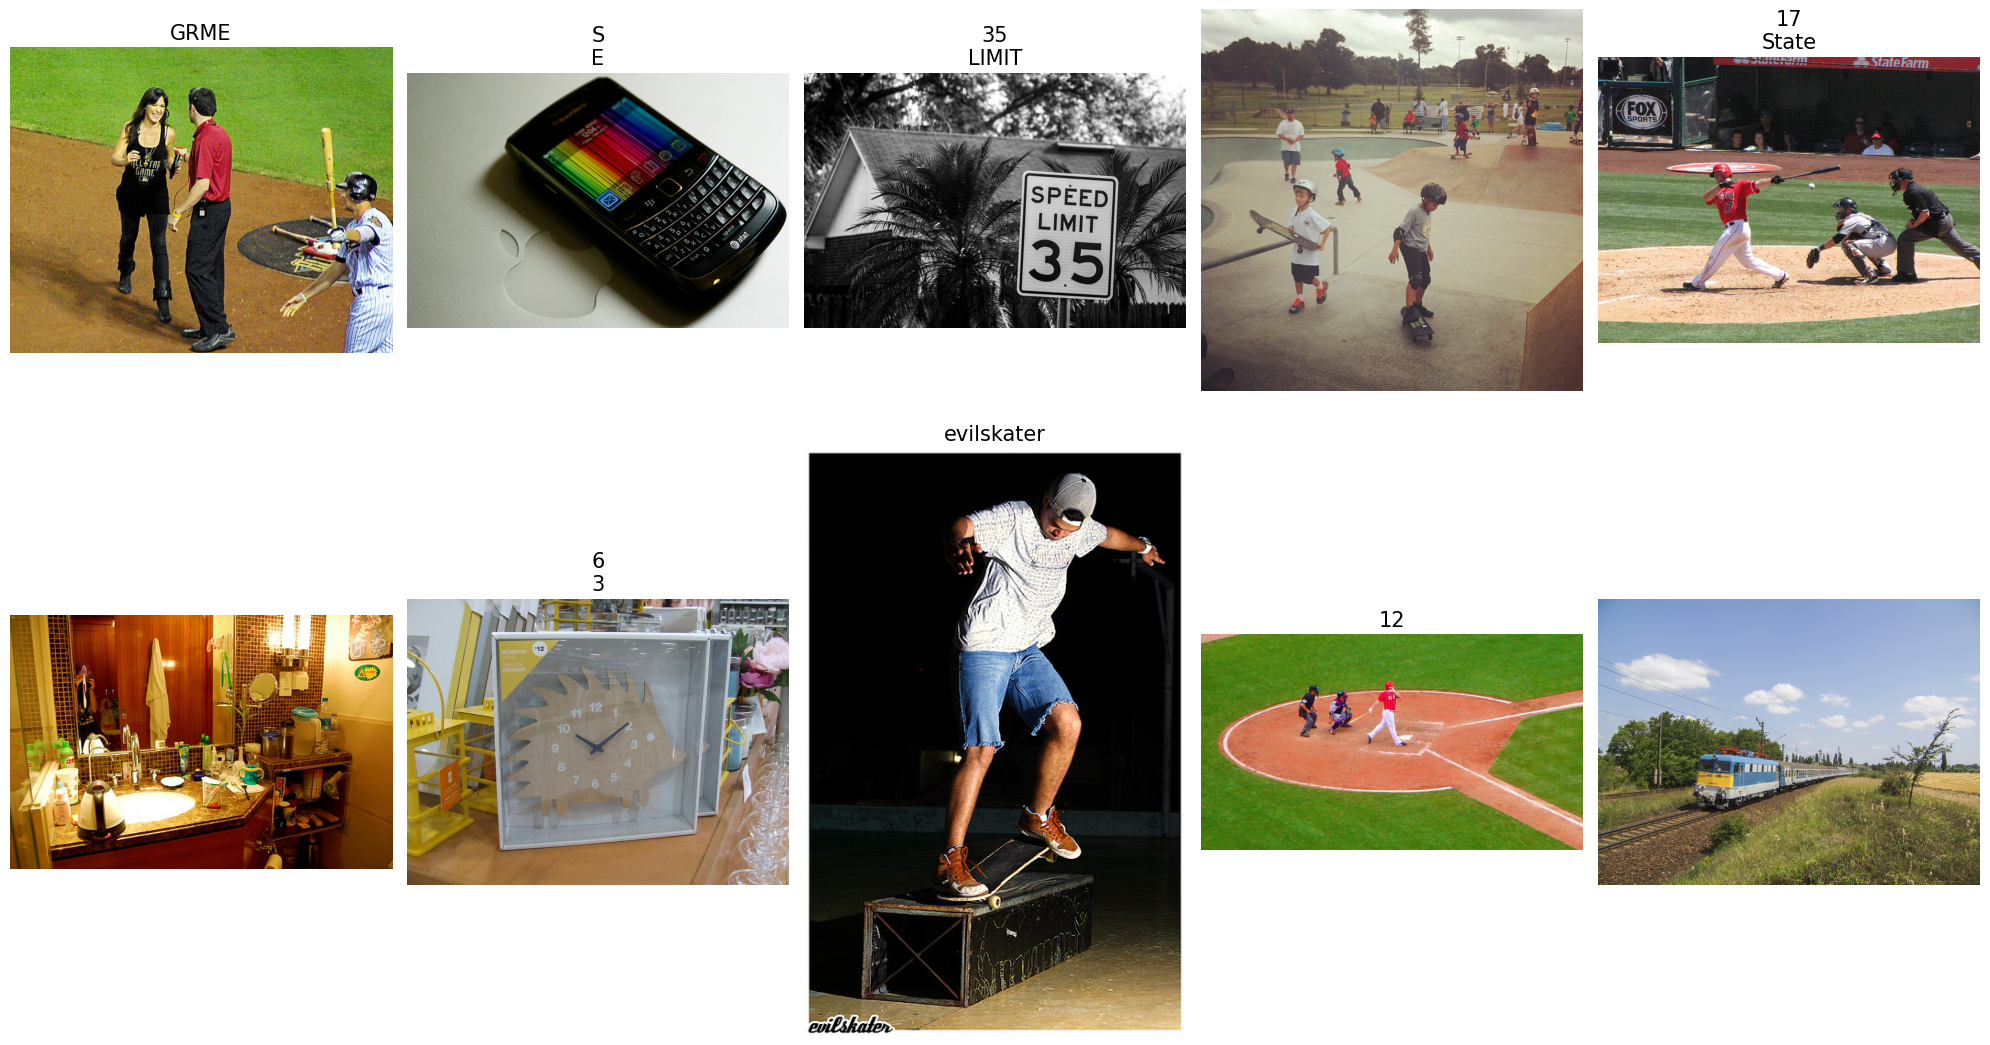

In [50]:
import matplotlib.pyplot as plt
from PIL import Image

with zipfile.ZipFile(annotations_zip, 'r') as zipf:
    with zipf.open('cocotext.v2.json') as file:
        coco_text = json.load(file)

id_to_filename = {
    int(k): v['file_name']
    for k, v in coco_text['imgs'].items()
    if v['set'] == 'train'
}

anotaciones_por_imagen = defaultdict(list)
for ann in coco_text['anns'].values():
    anotaciones_por_imagen[ann['image_id']].append(ann)

imagenes_disponibles = []
for img_id, filename in id_to_filename.items():
    ruta = os.path.join('../data/raw/subset/train2014/train2014', filename.split('/')[-1])
    if os.path.exists(ruta):
        imagenes_disponibles.append((img_id, ruta))
    if len(imagenes_disponibles) == 10:
        break

fig, axs = plt.subplots(2, 5, figsize=(20, 12))
axs = axs.flatten()

for i, (img_id, ruta_img) in enumerate(imagenes_disponibles):
    img = Image.open(ruta_img)
    axs[i].imshow(img)
    axs[i].axis('off')
    
    # get anns 
    textos = [
        ann['utf8_string']
        for ann in anotaciones_por_imagen[img_id]
        if ann['legibility'] == 'legible' and 'utf8_string' in ann
    ]
    
    axs[i].set_title('\n'.join(textos[:2]), fontsize=15)

plt.tight_layout()
plt.show()